In [8]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import scipy.stats as stats

from sklearn.ensemble import RandomForestClassifier
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory


# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [4]:
# %pip install scipy

Note: you may need to restart the kernel to use updated packages.


In [7]:
# %pip install scikit-learn

   ---------------------------------------- 0.0/10.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/10.9 MB 1.3 MB/s eta 0:00:09
   ---------------------------------------- 0.1/10.9 MB 1.3 MB/s eta 0:00:09
    --------------------------------------- 0.2/10.9 MB 1.9 MB/s eta 0:00:06
   - -------------------------------------- 0.5/10.9 MB 2.8 MB/s eta 0:00:04
   --- ------------------------------------ 1.0/10.9 MB 4.1 MB/s eta 0:00:03
   ----- ---------------------------------- 1.6/10.9 MB 5.7 MB/s eta 0:00:02
   ------ --------------------------------- 1.8/10.9 MB 6.5 MB/s eta 0:00:02
   ------ --------------------------------- 1.8/10.9 MB 6.5 MB/s eta 0:00:02
   --------- ------------------------------ 2.5/10.9 MB 5.9 MB/s eta 0:00:02
   ---------- ----------------------------- 3.0/10.9 MB 6.3 MB/s eta 0:00:02
   ------------ --------------------------- 3.5/10.9 MB 6.9 MB/s eta 0:00:02
   ------------ --------------------------- 3.5/10.9 MB 6.4 MB/s eta 0:00:02
   ---

In [9]:
X_train = pd.read_csv('train.csv')
X_test = pd.read_csv('test.csv')
gender_submission = pd.read_csv('gender_submission.csv')

In [10]:
y_train = X_train['Survived']
X_train = X_train.drop('Survived', axis = 1)

#name and ticket will not play any role
X_train = X_train.drop('Name',axis = 1)
X_train = X_train.drop('Ticket',axis = 1)

X_test = X_test.drop('Name',axis = 1)
X_test = X_test.drop('Ticket',axis = 1)

In [11]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Pclass       891 non-null    int64  
 2   Sex          891 non-null    object 
 3   Age          714 non-null    float64
 4   SibSp        891 non-null    int64  
 5   Parch        891 non-null    int64  
 6   Fare         891 non-null    float64
 7   Cabin        204 non-null    object 
 8   Embarked     889 non-null    object 
dtypes: float64(2), int64(4), object(3)
memory usage: 62.8+ KB


In [12]:
cat_vars = [var for var in X_train.columns if X_train[var].dtype == 'O']

In [13]:
num_vars = [var for var in X_train.columns if var not in cat_vars and var != 'PassengerId']

In [14]:
print("Categorical columns:",cat_vars)
print("Numeric columns:",num_vars)

Categorical columns: ['Sex', 'Cabin', 'Embarked']
Numeric columns: ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']


# Missing Values in categorical and Numeric columns

In [15]:
X_train[cat_vars].isnull().mean()

Sex         0.000000
Cabin       0.771044
Embarked    0.002245
dtype: float64

In [16]:
X_train['Cabin'] = X_train['Cabin'].apply(lambda x: x[0] if isinstance(x, str) else None)
X_test['Cabin'] = X_test['Cabin'].apply(lambda x: x[0] if isinstance(x, str) else None)

In [17]:
# more than 70 percent are missing - replacing the missing cabin alphabet with m
X_train['Cabin'] = X_train['Cabin'].fillna('M')
X_test['Cabin'] = X_test['Cabin'].fillna('M')

In [18]:
X_train['Cabin'].value_counts()

Cabin
M    687
C     59
B     47
D     33
E     32
A     15
F     13
G      4
T      1
Name: count, dtype: int64

In [19]:
embarked_mode = X_train['Embarked'].mode()[0]
X_train['Embarked'] = X_train['Embarked'].fillna(embarked_mode)
X_test['Embarked'] = X_test['Embarked'].fillna(embarked_mode)

In [20]:
X_train['Embarked'].value_counts()

Embarked
S    646
C    168
Q     77
Name: count, dtype: int64

In [21]:
X_train[num_vars].isnull().mean()

Pclass    0.000000
Age       0.198653
SibSp     0.000000
Parch     0.000000
Fare      0.000000
dtype: float64

In [22]:
# mean_age = X_train['Age'].mean()

X_train['Age'] = X_train['Age'].fillna(-1)
X_test['Age'] = X_test['Age'].fillna(-1)

# Numeric transformations

array([[<Axes: title={'center': 'Pclass'}>,
        <Axes: title={'center': 'Age'}>],
       [<Axes: title={'center': 'SibSp'}>,
        <Axes: title={'center': 'Parch'}>],
       [<Axes: title={'center': 'Fare'}>, <Axes: >]], dtype=object)

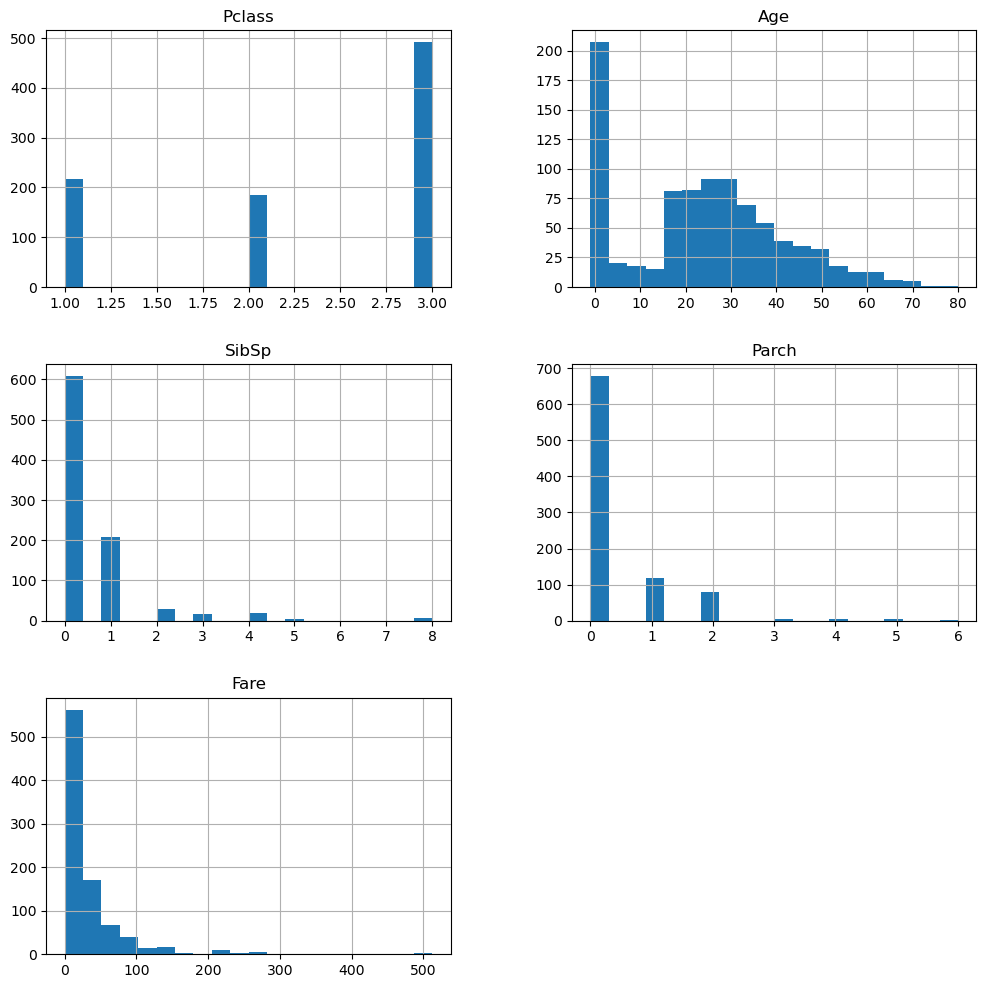

In [23]:
X_train[num_vars].hist(bins = 20, figsize = (12,12))

In [24]:
X_train['Fare'],param = stats.yeojohnson(X_train['Fare'])
X_test['Fare'] = stats.yeojohnson(X_test['Fare'], lmbda=param)

In [25]:
discrete_numeric = [var for var in num_vars if X_train[var].unique()[0] < 10]

In [26]:
X_train[discrete_numeric].isnull().sum()

Pclass    0
SibSp     0
Parch     0
Fare      0
dtype: int64

In [27]:
for var in cat_vars:
    get_dummies = pd.get_dummies(X_train[var],prefix = var,drop_first=True, dtype = 'int')
    test_dummies = pd.get_dummies(X_test[var], prefix = var,drop_first=True, dtype = 'int')
    X_train = pd.concat([X_train,get_dummies],axis = 1)
    X_test = pd.concat([X_test,test_dummies],axis = 1)

In [28]:
X_train.drop(cat_vars,axis = 1,inplace = True)
X_test.drop(cat_vars,axis = 1, inplace = True)

In [29]:
X_train.drop('Cabin_T',axis = 1, inplace = True)

In [30]:
X_train.head()

,PassengerId,Pclass,Age,SibSp,Parch,Fare,Sex_male,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_M,Embarked_Q,Embarked_S
0,1,3,22.0,1,0,1.906724,1,0,0,0,0,0,0,1,0,1
1,2,1,38.0,1,0,3.497640,0,0,1,0,0,0,0,0,0,0
2,3,3,26.0,0,0,1.970459,0,0,0,0,0,0,0,1,0,1
3,4,1,35.0,1,0,3.304258,0,0,1,0,0,0,0,0,0,1
4,5,3,35.0,0,0,1.981680,1,0,0,0,0,0,0,1,0,1


In [31]:
X_train.isnull().sum()

PassengerId    0
Pclass         0
Age            0
SibSp          0
Parch          0
Fare           0
Sex_male       0
Cabin_B        0
Cabin_C        0
Cabin_D        0
Cabin_E        0
Cabin_F        0
Cabin_G        0
Cabin_M        0
Embarked_Q     0
Embarked_S     0
dtype: int64

In [32]:
X_test.isnull().sum()

PassengerId    0
Pclass         0
Age            0
SibSp          0
Parch          0
Fare           1
Sex_male       0
Cabin_B        0
Cabin_C        0
Cabin_D        0
Cabin_E        0
Cabin_F        0
Cabin_G        0
Cabin_M        0
Embarked_Q     0
Embarked_S     0
dtype: int64

In [33]:
X_test['Fare'] = X_test['Fare'].isnull().fillna(-1)

In [34]:
from sklearn.metrics import accuracy_score, mean_squared_error
# Create a Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the Random Forest Classifier
rf_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_classifier.predict(X_test)

y_pred


array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [35]:
y_test = pd.concat([X_test['PassengerId'],pd.DataFrame(y_pred,columns = ['Survived'])], axis = 1)

In [36]:
y_test

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,1
4,896,0
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [37]:
y_test = y_test.set_index('PassengerId')

In [38]:
y_test.to_csv('y_predictions.csv')


In [40]:
accuracy_score(gender_submission.iloc[:,1].values, y_pred)

0.8803827751196173